# General Summary
The analyzed dataset contains records of domestic coffee consumption from 1990 to 2019, broken down by country and coffee type (Arabica, Robusta, Arabica/Robusta, and Robusta/Arabica). The dataset also includes the continent information for each country to facilitate aggregated analyses by region.

In [18]:
# Coffee Consumption Analysis

# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display
import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [19]:
# --------------------------------------
# Load and Explore Data
# --------------------------------------
url = "https://raw.githubusercontent.com/Jhonarsa/Coffee-data/refs/heads/main/02%20Data/2.%20Cleaned%20data/Coffee%20data%20cleaned.csv"
df = pd.read_csv(url)

# Prediction models

In [20]:
# ---------------------------
# Prepare aggregated series for modeling
# ---------------------------

# Aggregate to get total consumption per year across active countries
df_total = (
    df_activos.groupby("Year")["Consumption"]
    .sum()
    .reset_index()
    .rename(columns={"Year": "ds", "Consumption": "y"})
)

# Extract 4-digit year if string-like, convert to int
df_total["ds"] = df_total["ds"].astype(str).str.extract(r"^(\d{4})").astype(int)
#df_total["ds"] = df_total["ds"].str.extract(r"^(\d{4})").astype(int)

# Convert to date (January 1st of each year)
df_total["ds"] = pd.to_datetime(df_total["ds"].astype(str) + "-01-01")

df_total = df_total.sort_values("ds")
df_total["y"] = pd.to_numeric(df_total["y"], errors="coerce")


In [21]:
df_total["ds"].dtype


dtype('<M8[ns]')

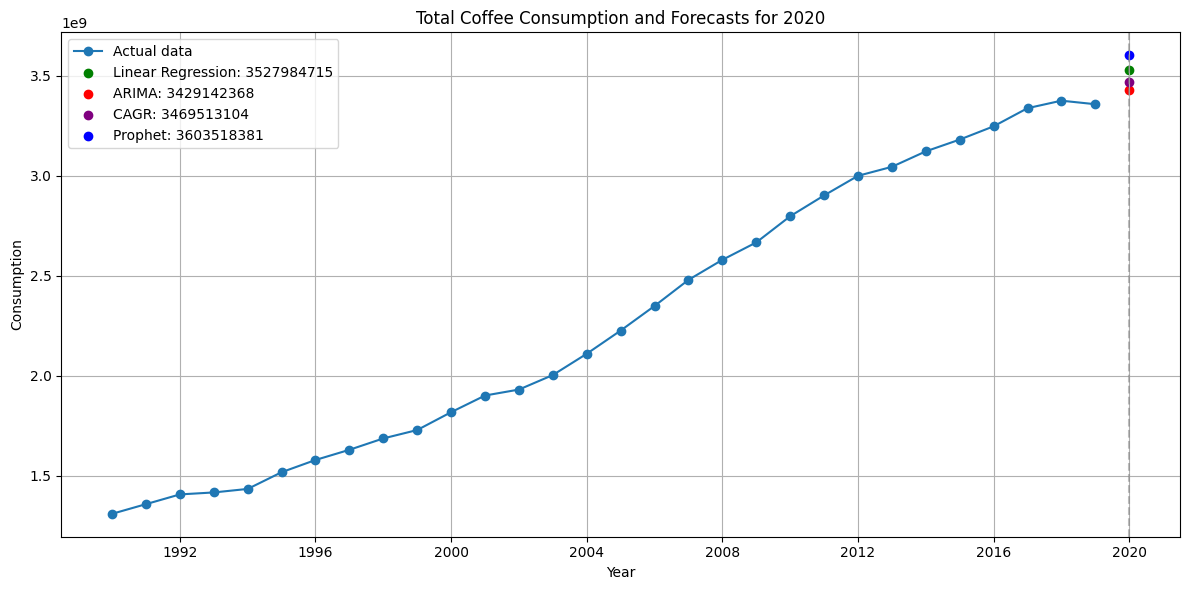

In [22]:
# ---------------------------
# Linear regression (baseline)
# ---------------------------
X = df_total["ds"].dt.year.values.reshape(-1, 1)
y = df_total["y"].values
lr_model = LinearRegression()
lr_model.fit(X, y)
pred_lr = lr_model.predict([[2020]])[0]

# ---------------------------
# ARIMA model selection helper
# ---------------------------
def seleccionar_mejor_arima(y, max_p=1, max_d=1, max_q=1):
    best_model = None
    best_aic = np.inf
    best_order = None

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(y, order=(p, d, q)).fit()
                    if model.aic < best_aic:
                        best_model = model
                        best_aic = model.aic
                        best_order = (p, d, q)
                except:
                    continue

    return best_model, best_order

modelo_auto, orden_arima = seleccionar_mejor_arima(df_total["y"])
pred_arima = modelo_auto.forecast(steps=1)

# ---------------------------
# CAGR forecast
# ---------------------------
start = df_total["y"].iloc[0]
end = df_total["y"].iloc[-1]
years = len(df_total) - 1
cagr = ((end / start) ** (1 / years)) - 1
pred_cagr = end * (1 + cagr)

# ---------------------------
# Prophet forecasting
# ---------------------------
prophet_df = df_total.copy()
model_prophet = Prophet(yearly_seasonality=True)
model_prophet.fit(prophet_df)

future = model_prophet.make_future_dataframe(periods=1, freq='Y')
forecast = model_prophet.predict(future)
pred_prophet = forecast[forecast['ds'].dt.year == 2019]["yhat"].iloc[-1]

# ---------------------------
# Plot actuals and forecasts for 2020
# ---------------------------
plt.figure(figsize=(12, 6))
plt.plot(df_total["ds"], df_total["y"], marker='o', label="Actual data")

# Add predictions for 2020
plt.scatter(pd.to_datetime("2020-01-01"), pred_lr, color='green', label=f"Linear Regression: {pred_lr:.0f}")
plt.scatter(pd.to_datetime("2020-01-01"), pred_arima.iloc[0], color='red', label=f"ARIMA: {pred_arima.iloc[0]:.0f}")
plt.scatter(pd.to_datetime("2020-01-01"), pred_cagr, color='purple', label=f"CAGR: {pred_cagr:.0f}")
plt.scatter(pd.to_datetime("2020-01-01"), pred_prophet, color='blue', label=f"Prophet: {pred_prophet:.0f}")

plt.axvline(pd.to_datetime("2020-01-01"), color='gray', linestyle='--', alpha=0.5)

plt.title("Total Coffee Consumption and Forecasts for 2020")
plt.xlabel("Year")
plt.ylabel("Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
# ---------------------------
# Create historical series DataFrame
# ---------------------------
df_hist = df_total.copy()
df_hist["Modelo"] = "Real"
df_hist.rename(columns={"ds": "Año", "y": "Consumo"}, inplace=True)

# ---------------------------
# Create DataFrame with predictions (for 2020)
# ---------------------------
df_preds = pd.DataFrame({
    "Año": [pd.to_datetime("2020-01-01")] * 4,
    "Consumo": [
        int(pred_lr),
        int(pred_arima.iloc[0]),
        int(pred_cagr),
        int(pred_prophet)
    ],
    "Modelo": ["Regresión Lineal", "ARIMA", "CAGR", "Prophet"]
})

# Combine historicals with predictions
df_final = pd.concat([df_hist, df_preds], ignore_index=True)

# Convert dates to year only (int) for Power BI
df_final["Año"] = df_final["Año"].dt.year

# Export to CSV
df_final.to_csv("consumo_con_predicciones.csv", index=False)

Total absolute error per model:
Prophet: 71951297.83
Regresión Lineal: 105749113.52
Promedio Móvil: 157801441.28
CAGR: 205464038.15
ARIMA: 128653682.83

✅ The best overall model is: **Prophet**


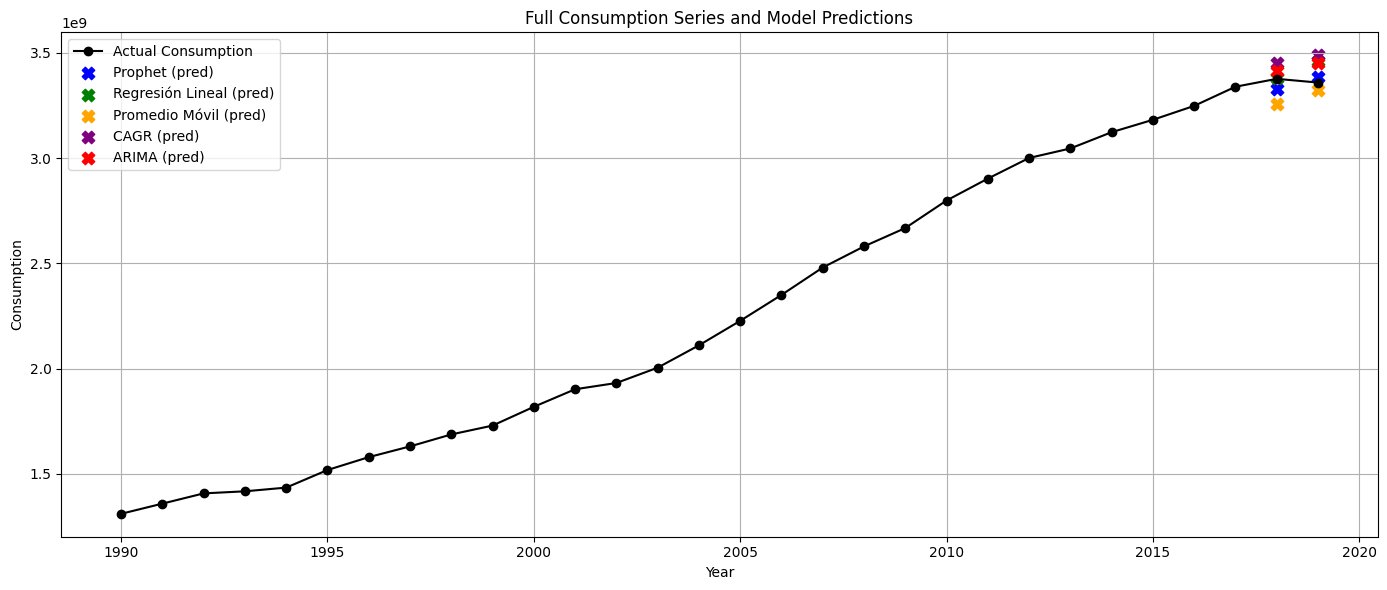

In [24]:
# ---------------------------
# Backtesting: list of years for backtest
# ---------------------------
backtest_years = [2018, 2019]

# Store results
results = []

for year in backtest_years:
    # Split train/test
    df_train = df_total[df_total["ds"].dt.year < year].copy()
    df_test = df_total[df_total["ds"].dt.year == year].copy()

    if df_test.empty or len(df_train) < 3:
        continue  # Skip if not enough data

    y_train = df_train["y"].values
    X_train = df_train["ds"].map(pd.Timestamp.toordinal).values.reshape(-1, 1)

    # ========== Model 1: Prophet ==========
    model_prophet = Prophet()
    model_prophet.fit(df_train)
    future = model_prophet.make_future_dataframe(periods=1, freq='Y')
    forecast_prophet = model_prophet.predict(future)
    pred_prophet = forecast_prophet[forecast_prophet["ds"].dt.year == (year - 1)]["yhat"].values[0]

    # ========== Model 2: Linear Regression ==========
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    pred_lr = lr_model.predict([[pd.Timestamp(f"{year}-01-01").toordinal()]])[0]

    # ========== Model 3: Moving Average ==========
    pred_ma = df_train["y"].tail(3).mean()

    # ========== Model 4: CAGR ==========
    start = df_train["y"].iloc[0]
    end = df_train["y"].iloc[-1]
    periods = len(df_train)
    cagr = ((end / start) ** (1 / periods)) - 1
    pred_cagr = end * (1 + cagr)

    # ========== Model 5: Automatic ARIMA ==========
    try:
        modelo_auto, orden_arima = seleccionar_mejor_arima(y_train)
        pred_arima = modelo_auto.forecast(steps=1)[0]
    except:
        pred_arima = np.nan

    # Actual value
    real = df_test["y"].values[0]

    # Store results (note: model names preserved as originally used in outputs)
    results.append({
        "Año": year,
        "Real": real,
        "Prophet": pred_prophet,
        "Regresión Lineal": pred_lr,
        "Promedio Móvil": pred_ma,
        "CAGR": pred_cagr,
        "ARIMA": pred_arima
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Calculate absolute errors per model
modelos = ["Prophet", "Regresión Lineal", "Promedio Móvil", "CAGR", "ARIMA"]
for modelo in modelos:
    results_df[f"Error_{modelo}"] = abs(results_df[modelo] - results_df["Real"])

# Total absolute error per model
errores_totales = {
    modelo: results_df[f"Error_{modelo}"].sum() for modelo in modelos
}

# Select best overall model
mejor_modelo_general = min(errores_totales, key=errores_totales.get)

# Display summary (translated text)
print("Total absolute error per model:")
for modelo, error in errores_totales.items():
    print(f"{modelo}: {error:.2f}")

print(f"\n✅ The best overall model is: **{mejor_modelo_general}**")

# ---------------------------
# Plot full series and predictions
# ---------------------------
plt.figure(figsize=(14, 6))

# Full line of actual data
plt.plot(df_total["ds"].dt.year, df_total["y"], marker='o', color="black", label="Actual Consumption")

# Add predictions for backtest years
colors = ["blue", "green", "orange", "purple", "red"]
for modelo, color in zip(modelos, colors):
    plt.scatter(results_df["Año"], results_df[modelo], label=f"{modelo} (pred)", color=color, s=80, marker='X')

plt.title("Full Consumption Series and Model Predictions")
plt.xlabel("Year")
plt.ylabel("Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Prepare full actual series for backtest export
# ---------------------------
serie_real = df_total.copy()
serie_real["Año"] = serie_real["ds"].dt.year
serie_real["Modelo"] = "Real"
serie_real.rename(columns={"y": "Consumo"}, inplace=True)
serie_real = serie_real[["Año", "Consumo", "Modelo"]]

# Restructure predictions to combine with actual series
predicciones = []
for modelo in modelos:
    temp = results_df[["Año", modelo]].copy()
    temp["Modelo"] = modelo
    temp.rename(columns={modelo: "Consumo"}, inplace=True)
    predicciones.append(temp)

df_pred = pd.concat(predicciones, ignore_index=True)

# Combine everything
df_final = pd.concat([serie_real, df_pred], ignore_index=True)

# Convert consumption to integer safely (avoids IntCastingNaNError)
# Option A: fill NaN with 0 before converting
df_final["Consumo"] = df_final["Consumo"].fillna(0).round(0).astype("int64")

# Option B (alternative): keep nullable integer dtype that allows NA
# df_final["Consumo"] = df_final["Consumo"].round(0).astype("Int64")

df_final.to_csv("backtesting.csv", index=False)


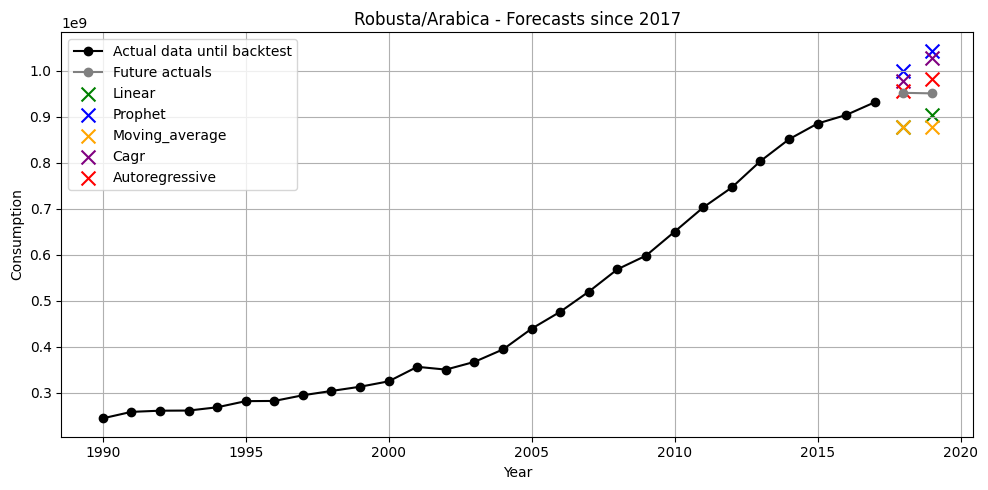

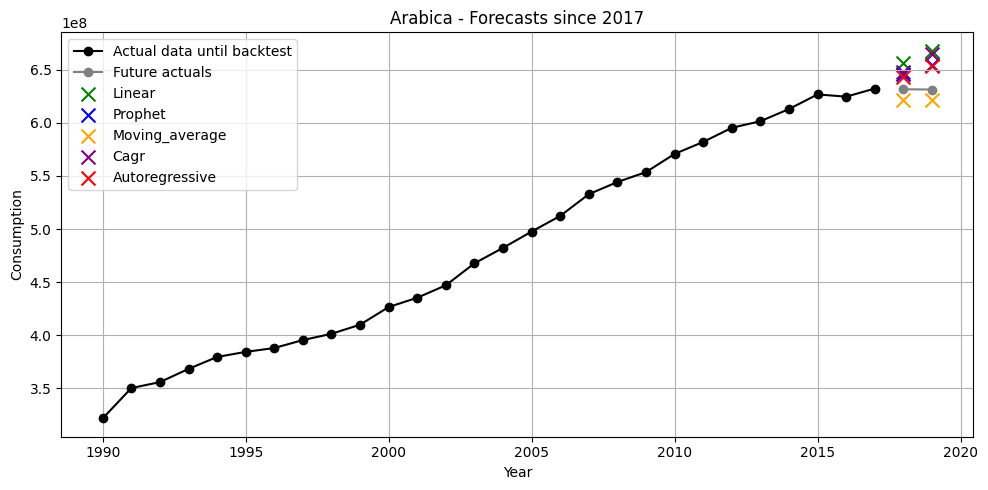

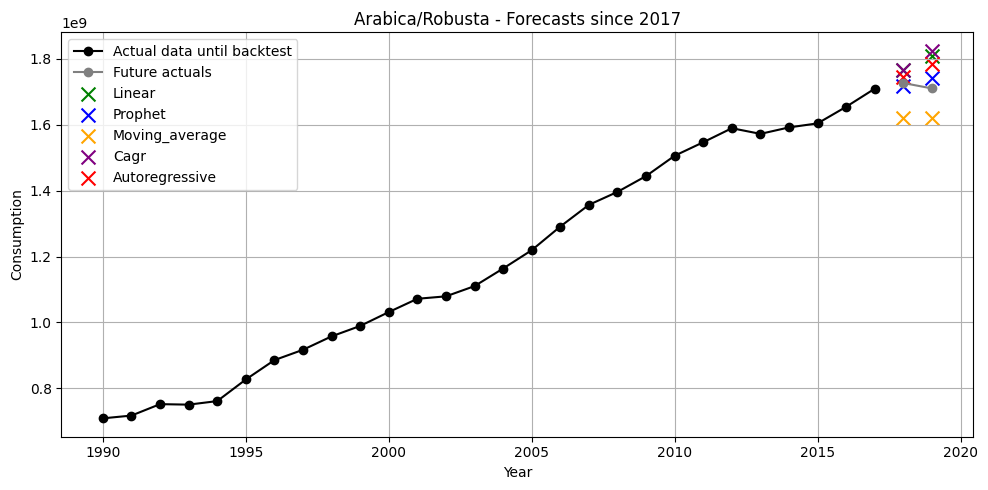

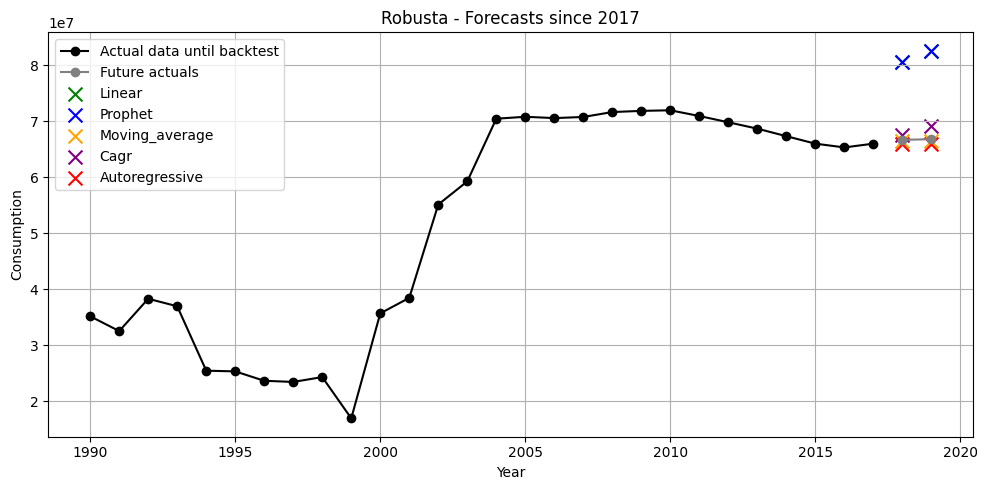


📋 Error metrics:


,Coffee,Model,MAE,RMSE
0,Robusta/Arabica,linear,61101879.28,62693757.60
1,Robusta/Arabica,prophet,70512108.78,73918468.16
2,Robusta/Arabica,moving_average,73523393.07,73525880.55
3,Robusta/Arabica,cagr,52200173.65,58069050.26
4,Robusta/Arabica,autoregressive,18043735.46,22388644.75
5,Arabica,linear,30431019.63,31042190.51
6,Arabica,prophet,18988730.39,19528550.37
7,Arabica,moving_average,10436826.03,10437751.20
8,Arabica,cagr,25016129.71,26372702.04
9,Arabica,autoregressive,16416492.67,17258516.51



✅ Best model per coffee type by RMSE:


,Coffee,Model,MAE,RMSE
0,Arabica,moving_average,1.043683e+07,1.043775e+07
1,Arabica/Robusta,prophet,2.145646e+07,2.417324e+07
2,Robusta,moving_average,2.952768e+05,3.028719e+05
3,Robusta/Arabica,autoregressive,1.804374e+07,2.238864e+07


In [25]:
# ---------------------------
# Flexible backtest by coffee type function
# ---------------------------
def backtest_forecast_flexible_clean(df_long, coffee_types, models=['linear', 'prophet'], backtest_start=2018):
    from sklearn.linear_model import LinearRegression
    from prophet import Prophet
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from statsmodels.tsa.ar_model import AutoReg

    results = []

    for coffee_type in coffee_types:
        data = df_long[df_long["Coffee type"] == coffee_type].copy()
        data = data.sort_values("Year")

        last_year = data["Year"].max()
        forecast_years = list(range(backtest_start + 1, last_year + 1))

        data_bt = data[data["Year"] <= backtest_start]
        data_grouped = data_bt.groupby("Year", as_index=False)["Consumption"].sum()
        X = data_grouped["Year"].values.reshape(-1, 1)
        y = data_grouped["Consumption"].values

        # Use real future aggregated values per year (if available)
        future_actuals_df = data.groupby("Year", as_index=False)["Consumption"].sum()
        future_actuals_df = future_actuals_df[future_actuals_df["Year"].isin(forecast_years)]
        y_real_future = future_actuals_df["Consumption"].values
        years_real_future = future_actuals_df["Year"].values

        forecast_dict = {}

        # LINEAR
        if "linear" in models:
            model_lr = LinearRegression().fit(X, y)
            X_future = np.array(forecast_years).reshape(-1, 1)
            y_pred_lr = model_lr.predict(X_future)
            forecast_dict["linear"] = y_pred_lr

        # PROPHET
        if "prophet" in models:
            prophet_df = pd.DataFrame({
                "ds": pd.to_datetime(data_grouped["Year"], format="%Y"),
                "y": y
            })
            model_prophet = Prophet(yearly_seasonality=False)
            model_prophet.fit(prophet_df)
            future = model_prophet.make_future_dataframe(periods=len(forecast_years), freq="Y")
            forecast = model_prophet.predict(future)
            # Fix end-of-year midnight shift if needed
            forecast['ds'] = forecast['ds'].apply(lambda d: d + pd.Timedelta(days=1) if d.month == 12 and d.day == 31 else d)
            forecast_preds = forecast[forecast["ds"].dt.year.isin(forecast_years)]["yhat"].values
            forecast_dict["prophet"] = forecast_preds

        # MOVING AVERAGE
        if "moving_average" in models:
            window = 3
            ma_series = data_grouped["Consumption"].rolling(window=window).mean()
            last_ma = ma_series.iloc[-window:].mean()
            forecast_dict["moving_average"] = np.array([last_ma] * len(forecast_years))

        # CAGR
        if "cagr" in models:
            start_val = y[0]
            end_val = y[-1]
            n_years = data_grouped["Year"].iloc[-1] - data_grouped["Year"].iloc[0]
            if start_val > 0 and n_years > 0:
                cagr = (end_val / start_val) ** (1 / n_years) - 1
                base = end_val
                forecast_dict["cagr"] = np.array([base * ((1 + cagr) ** i) for i in range(1, len(forecast_years) + 1)])

        # ARIMA helper inside function (keeps original Spanish name)
        def seleccionar_mejor_arima(y, max_p=1, max_d=1, max_q=1):
            mejor_modelo = None
            mejor_aic = np.inf
            mejor_orden = None

            for p in range(max_p + 1):
                for d in range(max_d + 1):
                    for q in range(max_q + 1):
                        try:
                            modelo = ARIMA(y, order=(p, d, q)).fit()
                            if modelo.aic < mejor_aic:
                                mejor_modelo = modelo
                                mejor_aic = modelo.aic
                                mejor_orden = (p, d, q)
                        except:
                            continue

            return mejor_modelo, mejor_orden

        if "autoregressive" in models:
            try:
                modelo_arima, orden_arima = seleccionar_mejor_arima(y)
                forecast_arima = modelo_arima.forecast(steps=len(forecast_years))
                forecast_dict["autoregressive"] = forecast_arima
            except Exception as e:
                print(f"Could not fit automatic ARIMA for {coffee_type}: {e}")

        # Visualization
        plt.figure(figsize=(10, 5))
        plt.plot(data_grouped["Year"], y, marker="o", color="black", label="Actual data until backtest")

        if len(y_real_future) > 0:
            plt.plot(years_real_future, y_real_future, marker="o", color="gray", label="Future actuals")

        color_map = {
            "linear": "green",
            "prophet": "blue",
            "moving_average": "orange",
            "cagr": "purple",
            "autoregressive": "red"
        }

        for model, preds in forecast_dict.items():
            if preds is not None and len(preds) == len(forecast_years):
                plt.scatter(forecast_years, preds, color=color_map.get(model, "gray"),
                            marker="x", s=100, label=model.capitalize())

                if len(y_real_future) == len(preds):
                    mae = mean_absolute_error(y_real_future, preds)
                    rmse = mean_squared_error(y_real_future, preds) ** 0.5
                    results.append({
                        "Coffee": coffee_type,
                        "Model": model,
                        "MAE": mae,
                        "RMSE": rmse
                    })

        plt.title(f"{coffee_type} - Forecasts since {backtest_start}")
        plt.xlabel("Year")
        plt.ylabel("Consumption")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    if results:
        df_resultados = pd.DataFrame(results)
        df_mejor_modelo = df_resultados.loc[df_resultados.groupby("Coffee")["RMSE"].idxmin()].reset_index(drop=True)

        print("\n📋 Error metrics:")
        display(df_resultados.round(2))

        print("\n✅ Best model per coffee type by RMSE:")
        display(df_mejor_modelo)

# ---------------------------
# Clean Year column before calling function
# ---------------------------
df_activos["Year"] = df_activos["Year"].astype(str).str.extract(r"^(\d{4})").astype(int)

backtest_forecast_flexible_clean(
    df_long=df_activos,
    coffee_types=['Robusta/Arabica', 'Arabica', 'Arabica/Robusta', 'Robusta'],  # adjust to real values in your column
    models=['linear', 'prophet', 'moving_average','cagr','autoregressive'],
    backtest_start=2017
)

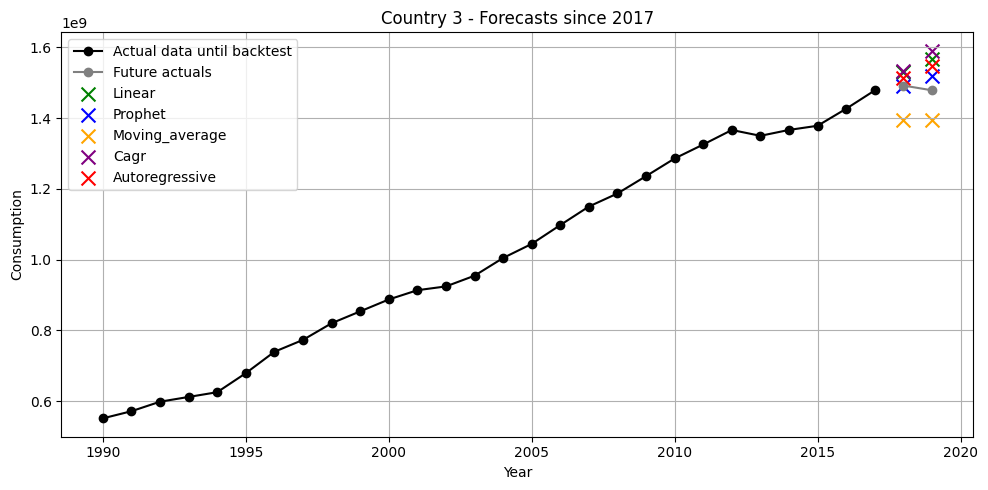

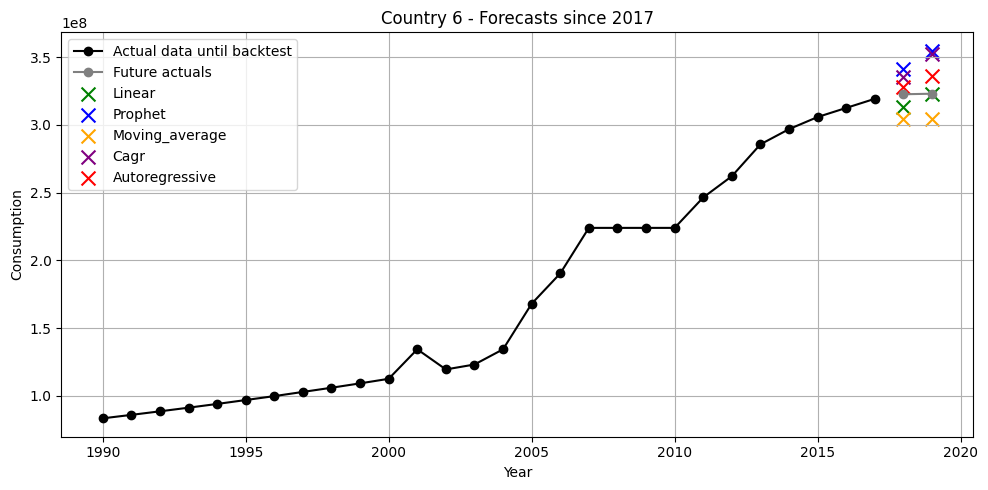

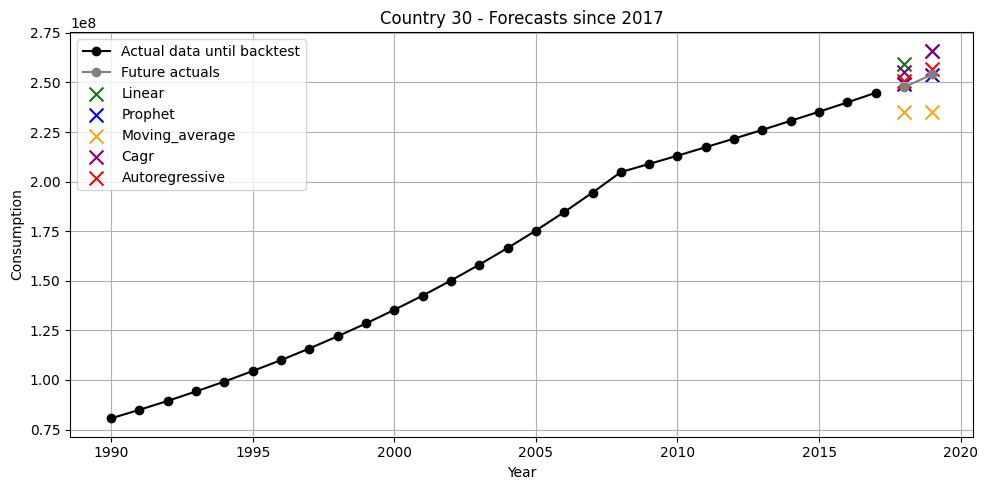

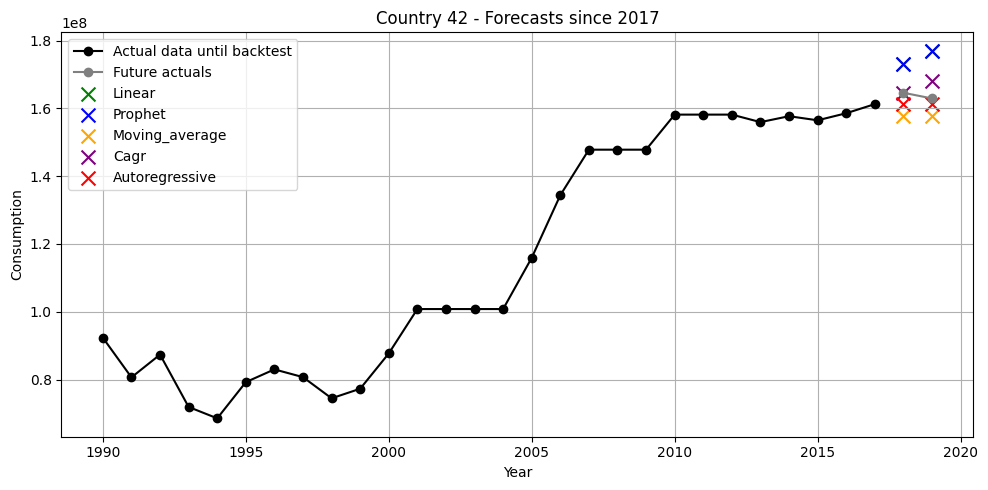

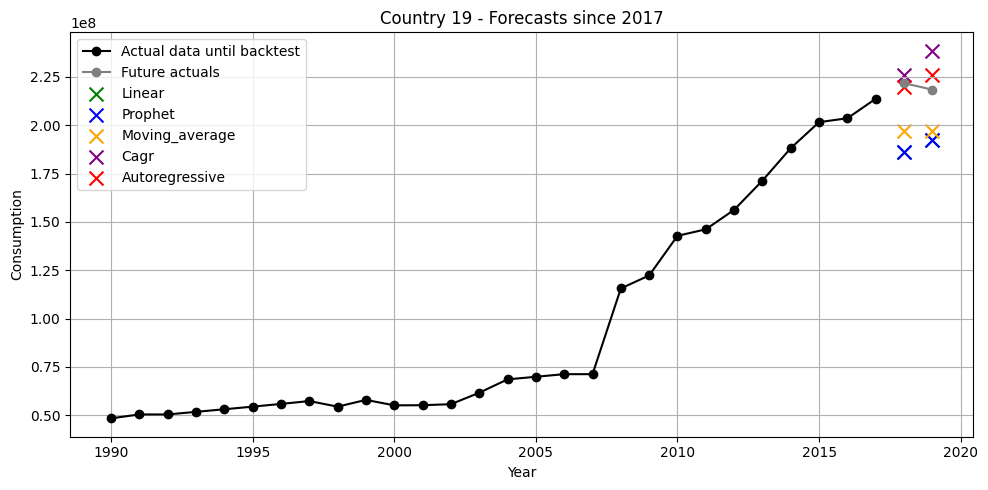

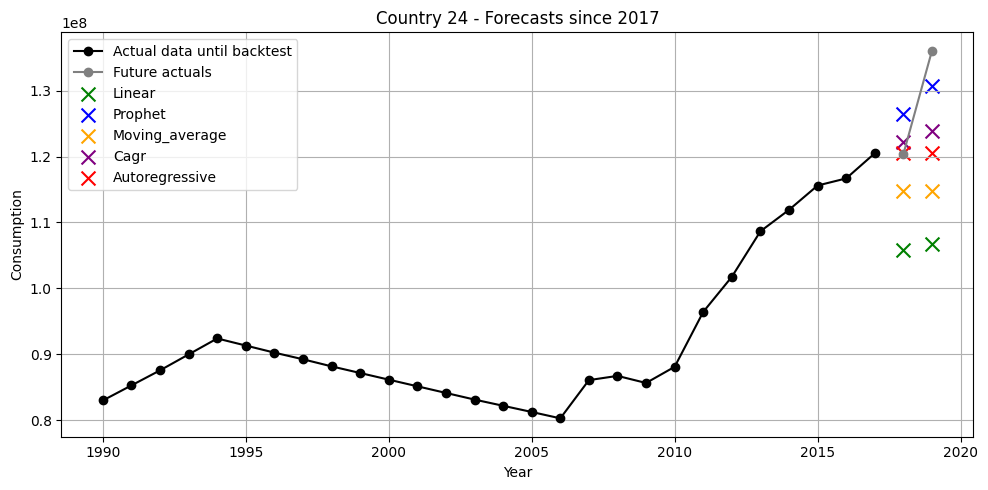

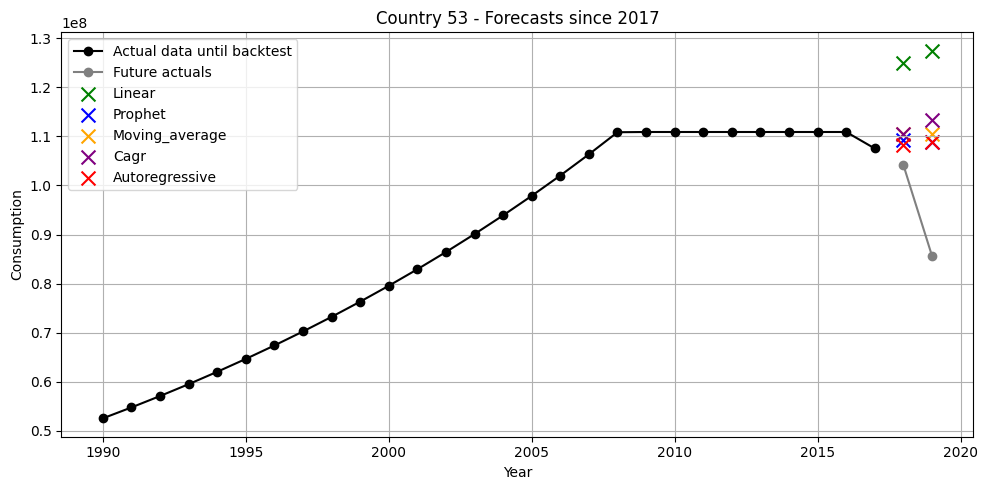

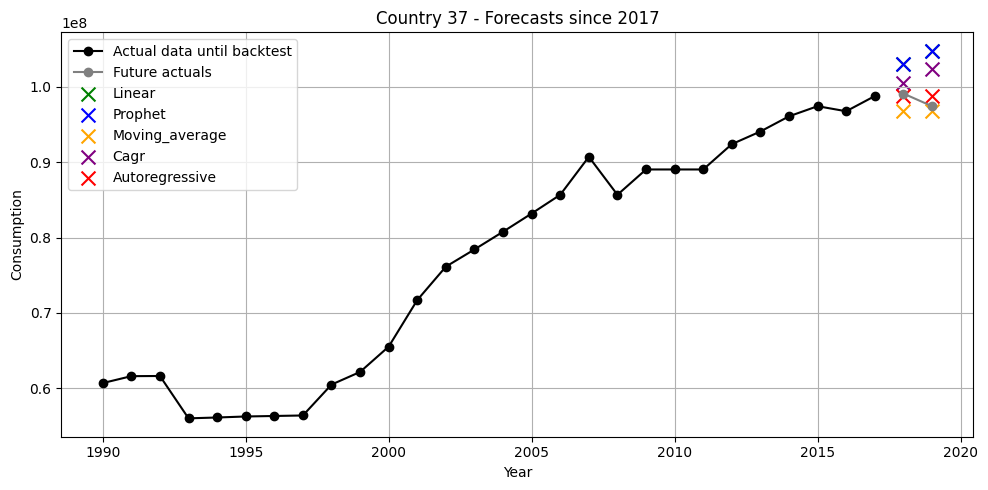

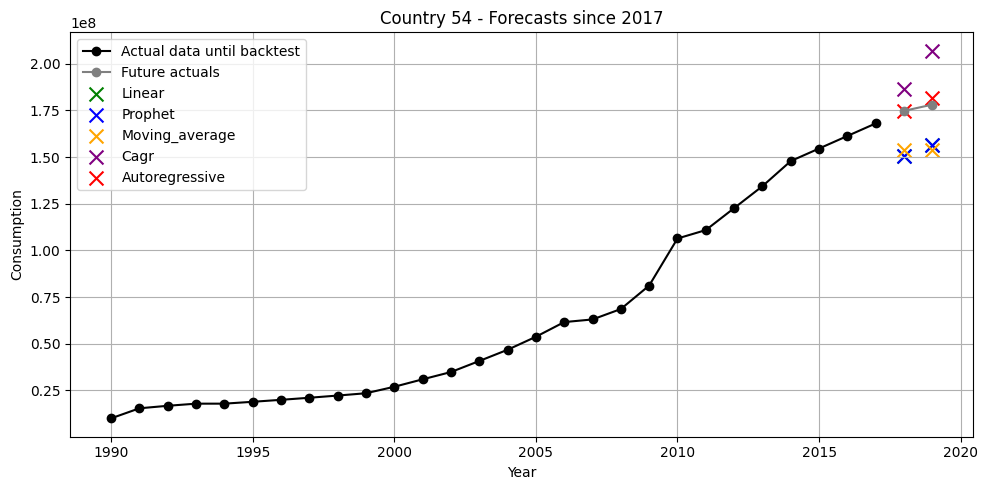

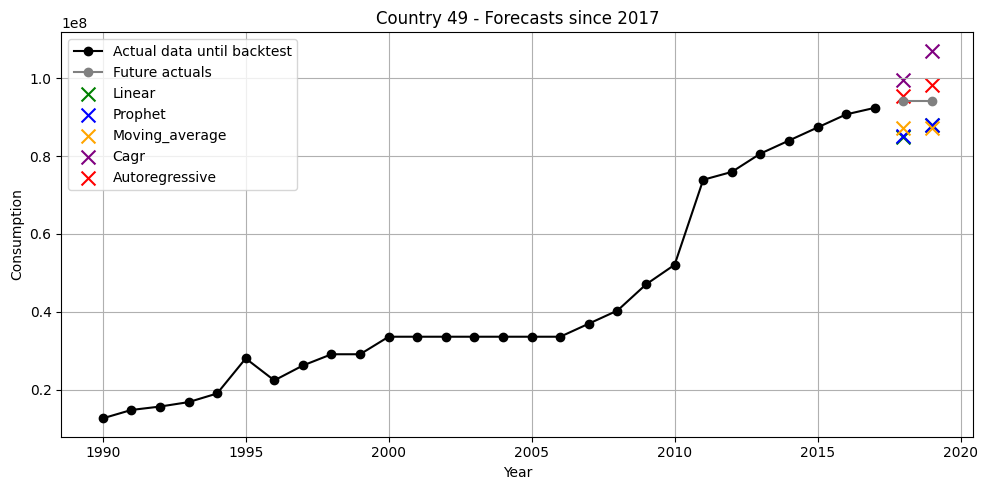


📋 Error metrics by country:


,Country,Model,MAE,RMSE
0,Country 3,linear,63105793.10,67790804.51
1,Country 3,prophet,20265483.60,28640496.82
2,Country 3,moving_average,90929066.67,91177045.16
3,Country 3,cagr,76637303.14,84357804.87
4,Country 3,autoregressive,44096608.89,50072218.18
5,Country 6,linear,4912386.21,6730728.54
6,Country 6,prophet,25316098.19,26114480.32
7,Country 6,moving_average,18241066.67,18242180.67
8,Country 6,cagr,21241200.78,22820575.31
9,Country 6,autoregressive,9122322.63,9970786.25



✅ Best model per country by RMSE:


,Country,Model,MAE,RMSE
0,Country 19,autoregressive,4.710588e+06,5.454498e+06
1,Country 24,prophet,5.716818e+06,5.725518e+06
2,Country 3,prophet,2.026548e+07,2.864050e+07
3,Country 30,prophet,9.445744e+05,1.082689e+06
4,Country 37,autoregressive,8.400000e+05,9.795999e+05
5,Country 42,autoregressive,2.520000e+06,2.656313e+06
6,Country 49,autoregressive,2.688102e+06,3.054453e+06
7,Country 53,autoregressive,1.354304e+07,1.656785e+07
8,Country 54,autoregressive,1.729179e+06,2.340922e+06
9,Country 6,linear,4.912386e+06,6.730729e+06


In [26]:
# ---------------------------
# Flexible backtest function by country
# ---------------------------
def backtest_forecast_flexible_by_country(df_long, countries, models=['linear', 'prophet'], backtest_start=2018):
    from sklearn.linear_model import LinearRegression
    from prophet import Prophet
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from statsmodels.tsa.arima.model import ARIMA

    results = []

    for country in countries:
        data = df_long[df_long["Country"] == country].copy()
        data = data.sort_values("Year")

        last_year = data["Year"].max()
        forecast_years = list(range(int(backtest_start) + 1, last_year + 1))

        data_bt = data[data["Year"] <= backtest_start]
        data_grouped = data_bt.groupby("Year", as_index=False)["Consumption"].sum()
        X = data_grouped["Year"].values.reshape(-1, 1)
        y = data_grouped["Consumption"].values

        future_actuals_df = data.groupby("Year", as_index=False)["Consumption"].sum()
        future_actuals_df = future_actuals_df[future_actuals_df["Year"].isin(forecast_years)]
        y_real_future = future_actuals_df["Consumption"].values
        years_real_future = future_actuals_df["Year"].values

        forecast_dict = {}

        if "linear" in models:
            model_lr = LinearRegression().fit(X, y)
            X_future = np.array(forecast_years).reshape(-1, 1)
            forecast_dict["linear"] = model_lr.predict(X_future)

        if "prophet" in models:
            prophet_df = pd.DataFrame({
                "ds": pd.to_datetime(data_grouped["Year"], format="%Y"),
                "y": y
            })
            model_prophet = Prophet(yearly_seasonality=False)
            model_prophet.fit(prophet_df)
            future = model_prophet.make_future_dataframe(periods=len(forecast_years), freq="YE")
            forecast = model_prophet.predict(future)
            forecast['ds'] = forecast['ds'].apply(lambda d: d + pd.Timedelta(days=1) if d.month == 12 and d.day == 31 else d)
            forecast_dict["prophet"] = forecast[forecast["ds"].dt.year.isin(forecast_years)]["yhat"].values

        if "moving_average" in models:
            window = 3
            ma_series = data_grouped["Consumption"].rolling(window=window).mean()
            forecast_dict["moving_average"] = np.array([ma_series.iloc[-window:].mean()] * len(forecast_years))

        if "cagr" in models:
            start_val = y[0]
            end_val = y[-1]
            n_years = data_grouped["Year"].iloc[-1] - data_grouped["Year"].iloc[0]
            if start_val > 0 and n_years > 0:
                cagr = (end_val / start_val) ** (1 / n_years) - 1
                base = end_val
                forecast_dict["cagr"] = np.array([base * ((1 + cagr) ** i) for i in range(1, len(forecast_years) + 1)])

        def seleccionar_mejor_arima(y, max_p=1, max_d=1, max_q=1):
            mejor_modelo = None
            mejor_aic = np.inf
            mejor_orden = None

            for p in range(max_p + 1):
                for d in range(max_d + 1):
                    for q in range(max_q + 1):
                        try:
                            modelo = ARIMA(y, order=(p, d, q)).fit()
                            if modelo.aic < mejor_aic:
                                mejor_modelo = modelo
                                mejor_aic = modelo.aic
                                mejor_orden = (p, d, q)
                        except:
                            continue

            return mejor_modelo, mejor_orden

        if "autoregressive" in models:
            try:
                modelo_arima, orden_arima = seleccionar_mejor_arima(y)
                forecast_arima = modelo_arima.forecast(steps=len(forecast_years))
                forecast_dict["autoregressive"] = forecast_arima
            except Exception as e:
                print(f"Could not fit automatic ARIMA for {country}: {e}")

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(data_grouped["Year"], y, marker="o", color="black", label="Actual data until backtest")

        if len(y_real_future) > 0:
            plt.plot(years_real_future, y_real_future, marker="o", color="gray", label="Future actuals")

        color_map = {
            "linear": "green",
            "prophet": "blue",
            "moving_average": "orange",
            "cagr": "purple",
            "autoregressive": "red"
        }

        for model, preds in forecast_dict.items():
            if preds is not None and len(preds) == len(forecast_years):
                plt.scatter(forecast_years, preds, color=color_map.get(model, "gray"),
                            marker="x", s=100, label=model.capitalize())

                if len(y_real_future) == len(preds):
                    mae = mean_absolute_error(y_real_future, preds)
                    rmse = mean_squared_error(y_real_future, preds) ** 0.5
                    results.append({
                        "Country": country,
                        "Model": model,
                        "MAE": mae,
                        "RMSE": rmse
                    })

        plt.title(f"{country} - Forecasts since {backtest_start}")
        plt.xlabel("Year")
        plt.ylabel("Consumption")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    if results:
        df_resultados = pd.DataFrame(results)
        df_mejor_modelo = df_resultados.loc[df_resultados.groupby("Country")["RMSE"].idxmin()].reset_index(drop=True)

        print("\n📋 Error metrics by country:")
        display(df_resultados.round(2))

        print("\n✅ Best model per country by RMSE:")
        display(df_mejor_modelo)

# ---------------------------
# Run backtest for top 10 countries
# ---------------------------
top10_countries = (
    df_activos.groupby("Country", as_index=False)["Consumption"]
    .sum()
    .sort_values("Consumption", ascending=False)
    .head(10)["Country"]
    .tolist()
)

backtest_forecast_flexible_by_country(
    df_long=df_activos,
    countries=top10_countries,
    models=["linear", "prophet", "moving_average", "cagr", "autoregressive"],
    backtest_start=2017
)

**Modeling Approach**

*   The time series for each country and coffee type were cleaned and transformed,removing initial zeros and excluding countries with no consumption in the last year of the observed period.

*   Various modeling approaches were applied to forecast future consumption:

  -  Linear trend: useful for capturing steady growth.

  -  Prophet (Meta): suitable for series with seasonality or trend shifts.

  -  Automatic ARIMA: selected for its ability to model autoregressive structures and fit stationary patterns.

  -  Moving average and CAGR: used as simple benchmark methods.

*   To validate the models, a backtesting scheme was applied for the years 2018 and 2019, comparing predictions with the actual values observed in those years.

*   Additionally, a forecast was generated for the year 2020. In most cases, the automatic ARIMA model visually provided more accurate predictions, aligning more closely with the actual consumption trajectory.